In [2]:
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import  MaxPooling1D, Flatten
from keras.callbacks import TensorBoard
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats.stats import pearsonr
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from math import log
from scipy import stats

Using TensorFlow backend.


In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [4]:
#importacion de los datos
dataset = read_csv('izn2.csv', header=0, index_col=0)
y=dataset['ESCAMA ']
chlor_a=dataset['chlor_a']
Rain=dataset['Rain']
sst=dataset['sst']
ICC=dataset['ICC']
ALMEJAS=dataset['ALMEJAS']
CAMARON=dataset['CAMARON']
JAIBA=dataset['JAIBA']
TIBURONES=dataset['TIBURONES Y RAYA']
IPC=dataset['IPC']
x=pd.concat([sst,chlor_a,Rain,ALMEJAS,CAMARON,JAIBA,TIBURONES], axis=1)
target=pd.concat([y,x],axis=1)

In [5]:
mvar,nvar=x.shape 
values = target.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float64')
values= pd.DataFrame(values).fillna(0)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
delay = 6
Lpron = 12
Batch_size=350
Epochs=1500
reframed = series_to_supervised(scaled,1, delay)

lx,ly=reframed.shape
for i in range(1,nvar+1):
    reframed.drop(reframed.columns[[ly-i]],axis=1,inplace=True)

long1,limit1 = reframed.shape

#  reframed.columns.values.tolist()
len(reframed)
# split into train and test sets
values = reframed.values
n_train_hours = len(reframed)-48
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
limit= limit1-1
train_X, train_y = train[:, :limit], train[:, limit:]#aqui cambia según el núúmero de variables independientes que
test_X, test_y = test[:, :limit], test[:, limit:]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

#diseño del modelo
model = Sequential()
model.add(Dense(15, activation='tanh',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(25, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(20,activation='tanh'))
model.add(LSTM(5,return_sequences=True,activation='tanh',input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop' ,metrics=['accuracy'])

#entrenaimento
history = model.fit(train_X, train_y,
                    epochs=Epochs,
                    batch_size=Batch_size,
                    validation_data=(test_X, test_y),
                    verbose=0,shuffle=False)

#make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X[:,:nvar]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

# invert scaling for actual
test_y2 = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y2, test_X[:, :nvar]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:1]

real=inv_y[:Lpron,0]
forecast=inv_yhat[:Lpron,0]

In [6]:
def calculate_aic(n, mse, num_params):
	aic = n * log(mse) + 2 * num_params
	return aic

def calculate_bic(n, mse, num_params):
	bic = n * log(mse) + num_params * log(n)
	return bic

In [7]:
r=pearsonr(inv_y[:Lpron,0], inv_yhat[:Lpron,0])
mse= mean_squared_error(inv_y[:Lpron,0], inv_yhat[:Lpron,0])
rmse=mse**(1/2)
aic = calculate_aic(long1-Lpron, mse, limit1)
bic = calculate_bic(long1-Lpron,mse,limit1)
tStat, pValue = stats.ttest_ind(real, forecast, equal_var = False) #run independent sample T-Test

print('variables', list(x.columns.values) )
print('number of parameters', limit1)
print('delayed time', delay)
print('Batch size', Batch_size)
print('Epoch', Epochs)
print('R =  %.4f ' %r[0])
print('RMSE =  %.0f ' %rmse)
print('AIC = %.0f' %aic)
print('BIC = %.0f' %bic)
print('P-Value = %.4f' %pValue)
print('T-Statistic = %.4f'%tStat)


variables ['sst', 'chlor_a', 'Rain', 'ALMEJAS', 'CAMARON', 'JAIBA', 'TIBURONES Y RAYA']
number of parameters 49
delayed time 6
Batch size 350
Epoch 1500
R =  0.9305 
RMSE =  152365 
AIC = 3821
BIC = 3971
P-Value = 0.4713
T-Statistic = 0.7334


In [8]:
deltay= inv_y[:Lpron,0]-inv_yhat[:Lpron,0]
prom=deltay.mean()
desv=deltay.std()
n=len(deltay)**(1/2)
Za=1.28
bc=Za*(desv/n)
up=inv_yhat[:Lpron,0]+desv
down=inv_yhat[:Lpron,0]-desv

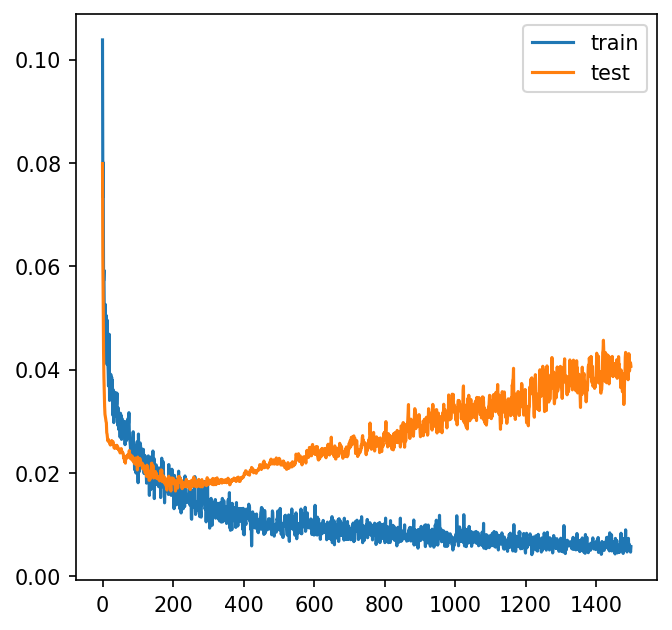

In [9]:
fig2=pyplot.figure(figsize=(5,5),dpi=150, facecolor='w', edgecolor='k')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
fig2.savefig('entrenamiento.png')

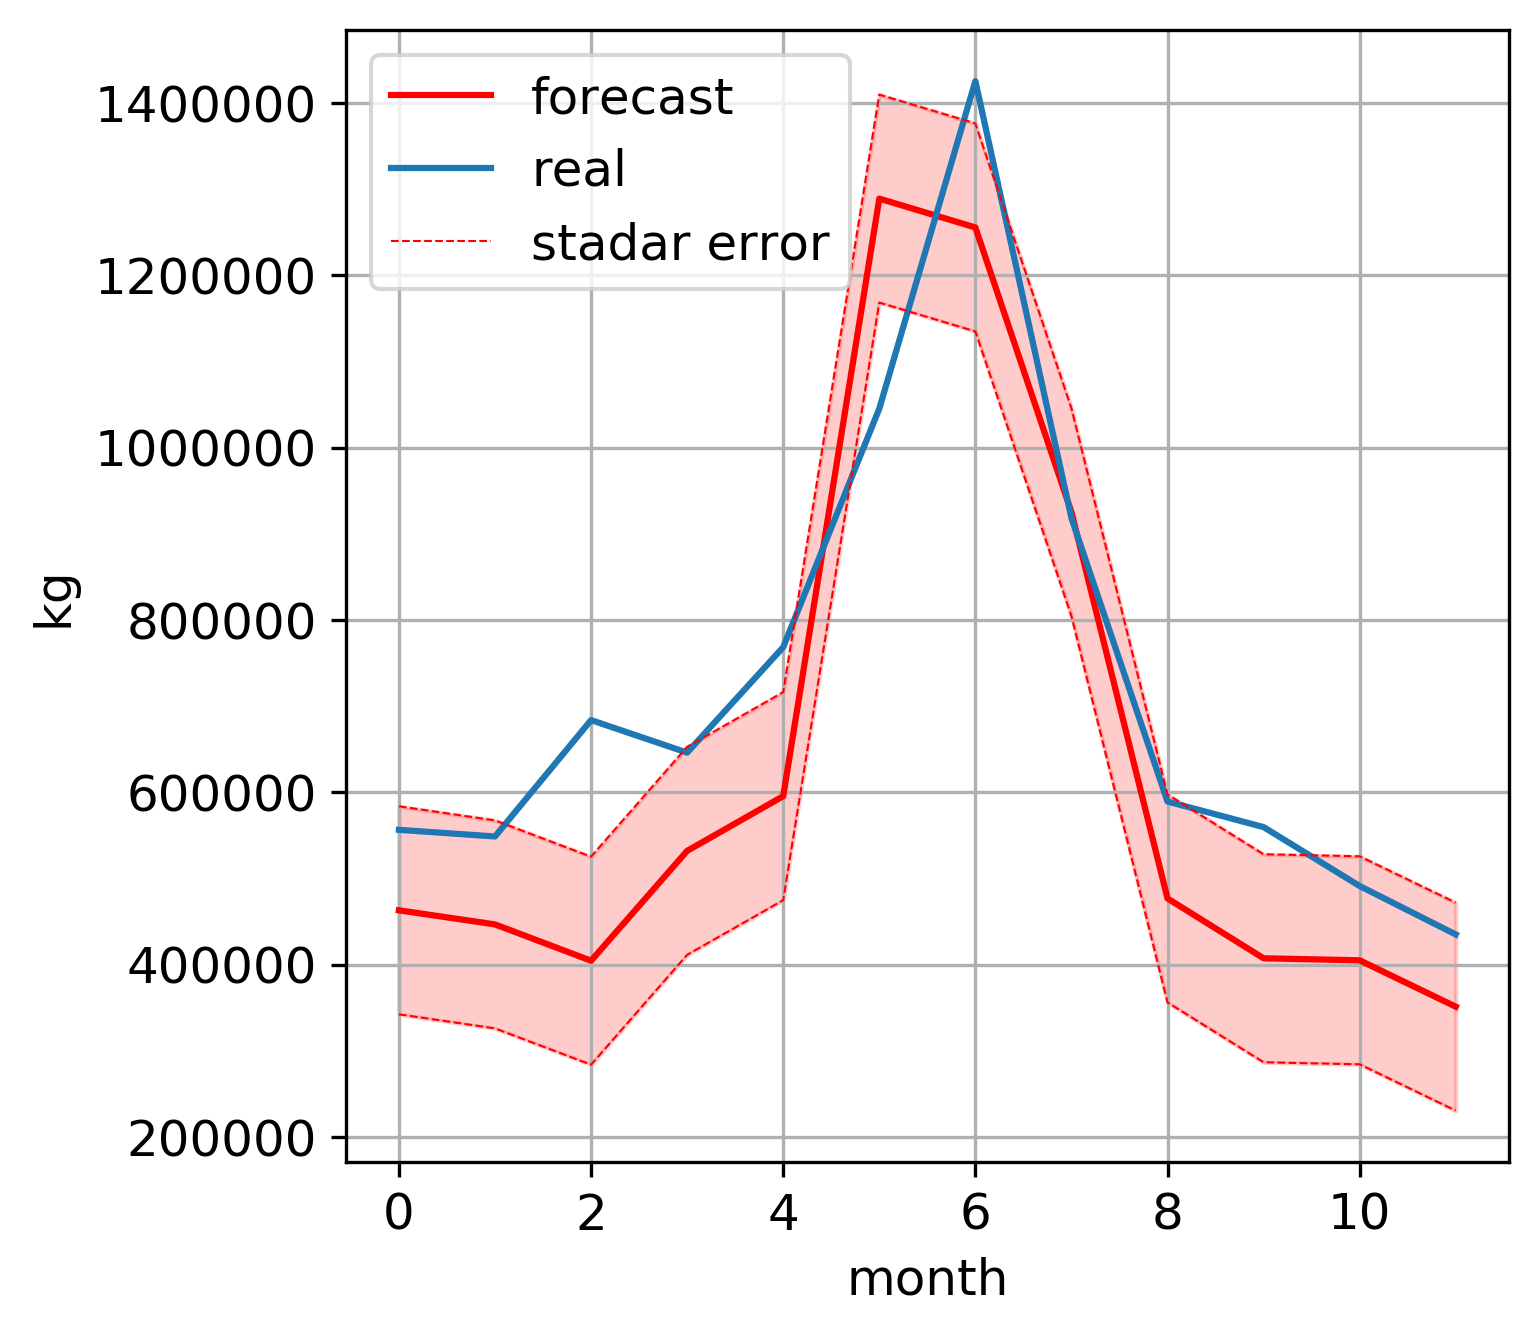

In [11]:
fig=pyplot.figure(figsize=(5,5),dpi=300, facecolor='w', edgecolor='k')
ax=pyplot.plot(inv_yhat[:Lpron,0], 'r',label='forecast',linewidth=1.5)
ax=pyplot.plot(inv_y[:Lpron,0], label='real',linewidth=1.5)
ax=pyplot.plot(up[:], 'r',  linestyle='dashed',linewidth=0.5,label="stadar error")
ax=pyplot.plot(down[:], 'r',  linestyle='dashed',linewidth=0.5)
ax=pyplot.fill_between(np.arange(len(inv_y[:Lpron,0])),down[:],up[:],color='r',alpha=0.2)
ax=pyplot.xlabel('month',fontsize=12)
ax=pyplot.ylabel('kg',fontsize=12)
ax=pyplot.tick_params(axis='both', which='major', labelsize=12)
#pyplot.text(10,20, 'Test R = %.5f' %r[0], fontsize=10)
ax=pyplot.grid()
ax=pyplot.legend(fontsize=12)
fig.savefig('pron-val-zn2-year.png')